In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
df0=pd.read_csv('heart.csv')

In [3]:
df0

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# 1. Exploratory Data Analysis

## Objectif :
- Comprendre du mieux possible nos données
- Développer une première stratégie de modélisation 

## Checklist de base
#### Analyse de Forme :
- **variable target** : HeartDisease, binaire (0 si normal, 1 si maladie cardiaque)
- **lignes et colonnes** : 918, 12
- **types de variables** : qualitatives : 5, quantitatives : 7
- **Analyse des valeurs manquantes** : Aucune valeur manquante

In [4]:
df0.shape

(918, 12)

In [5]:
df0.dtypes.value_counts()

int64      6
object     5
float64    1
dtype: int64

In [6]:
df0['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### Analyse de Fond :
- **Visualisation de la target** :
    - 55% de positifs (508 / 918) -> assez équilibré
    
- **Signification des variables** :
    - Age: plutôt normale sur la plage de 25 à 80 ans
    - RestingBP: resting blood pressure [mm Hg] (Pression sanguine au repos) distribution normale, mais présence d'une valeur nulle --> outlier --> La retirer lors du preprocessing
    - Cholesterol: Taux de cholesterol [mmol/dl], distribution normale sauf pour beaucoup de valeurs valant 0:   & présence de outliers potentiels --> 
    - MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
    - ST_Slope: slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
    - Oldpeak: oldpeak = ST [in depression] (represents how ST segment is abnormally low below the baseline)
    - ExerciseAngina: indique si oui ou non le test 'exercise angina' a été appliqué, on peut retirer cette feature
    
- **Relation Variables / Target** :
    - L'âge semble être corrélé à la maladie cardiaque - plus le patient est agé, plus il risque d'être malade --> hypothèse à tester
    - De la même manière, les variables continues MaxHR & Oldpeak et RestingBP semblent être liées à l'output
    - Le sexe (H/F) semble lui aussi corrélé - Les hommes semblent être plus affectés que les femmes --> hypothèse à tester
    - ChestPainType: les douleurs de type angine atypique (Atypical Angina) semblent induire des maladies cardiaques, plus que les autres douleurs
    - Le cholesterol et le resting ECG ne semblent pas influer sur la présence de maladies cardiaques

##### histogrames des variables quantitatives 

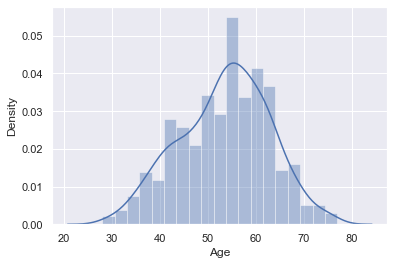

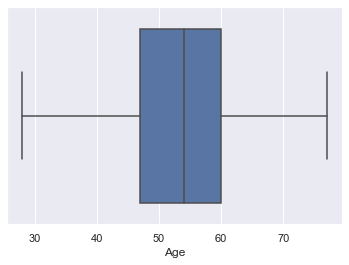

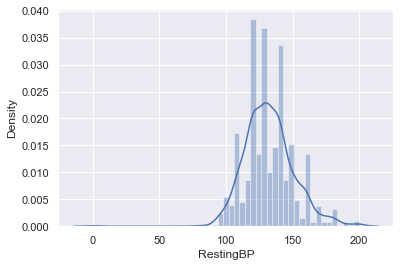

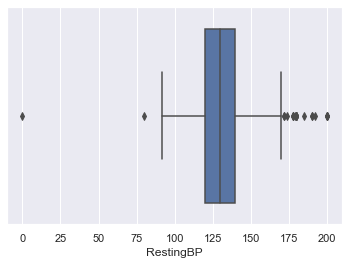

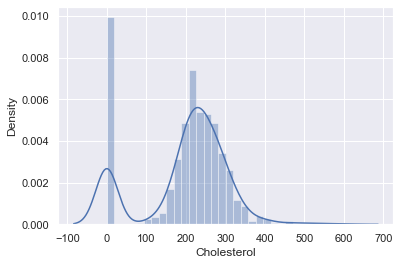

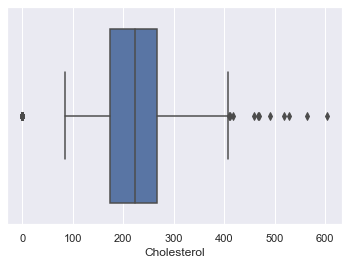

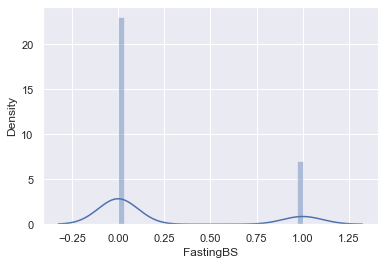

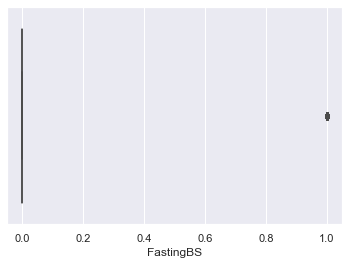

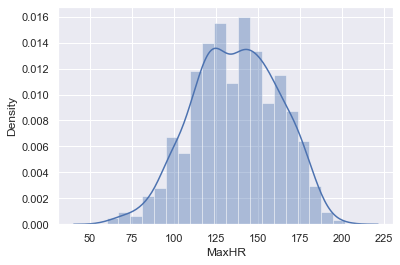

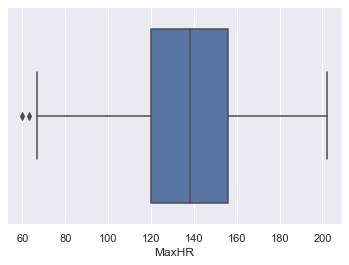

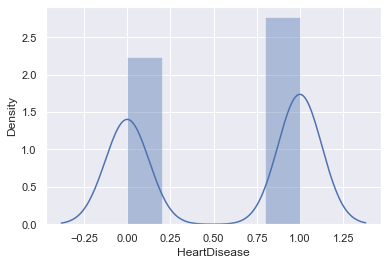

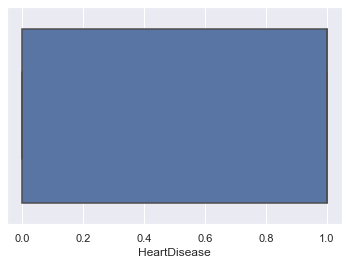

In [8]:
for col in df0.select_dtypes('int'):
    plt.figure()
    sns.distplot(df0[col])
    plt.figure()
    sns.boxplot(x=df0[col])


In [9]:
df0['FastingBS'].value_counts()

0    704
1    214
Name: FastingBS, dtype: int64

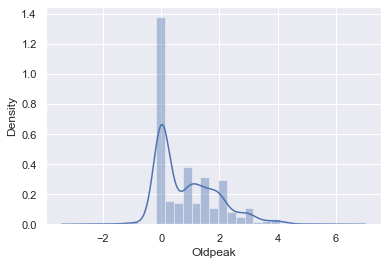

In [10]:
for col in df0.select_dtypes('float'):
    plt.figure()
    sns.distplot(df0[col])

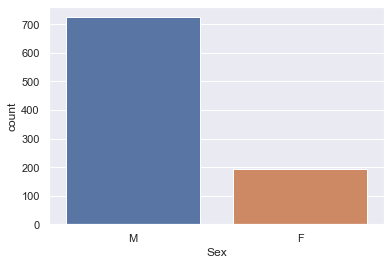

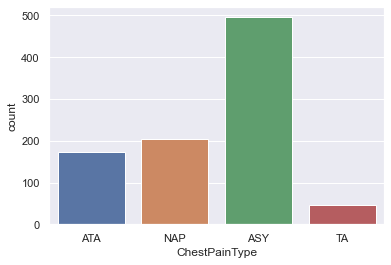

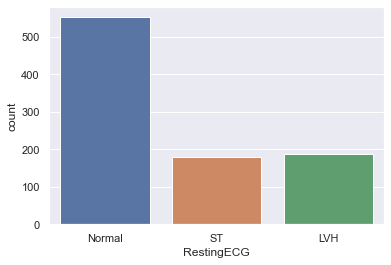

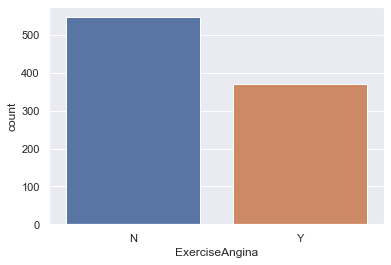

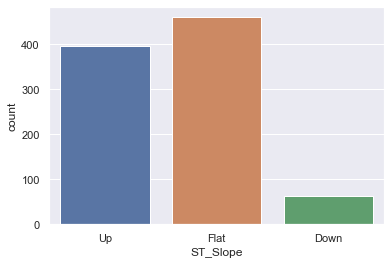

In [11]:
for col in df0.select_dtypes('object'):
    plt.figure()
    sns.countplot(x=col, data=df0)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

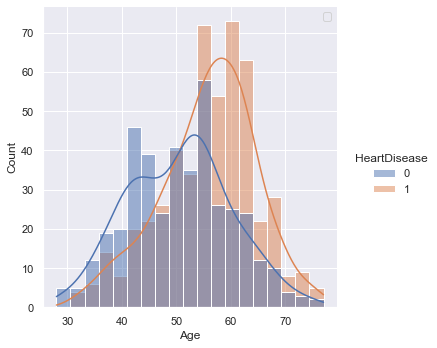

<Figure size 432x288 with 0 Axes>

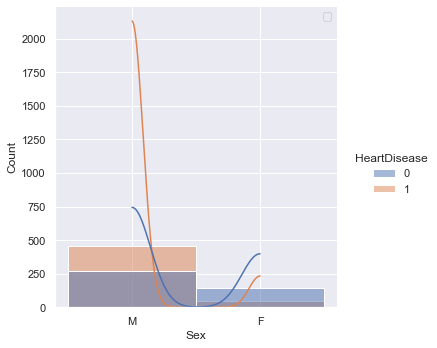

<Figure size 432x288 with 0 Axes>

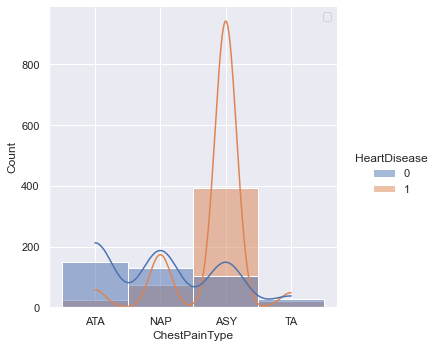

<Figure size 432x288 with 0 Axes>

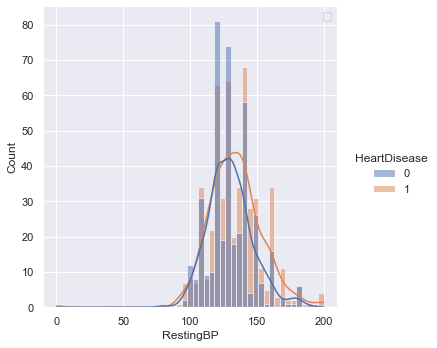

<Figure size 432x288 with 0 Axes>

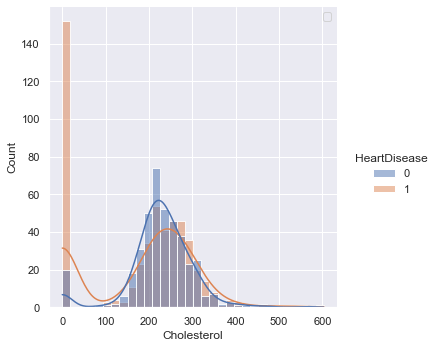

<Figure size 432x288 with 0 Axes>

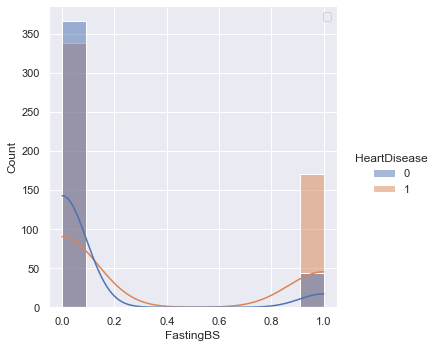

<Figure size 432x288 with 0 Axes>

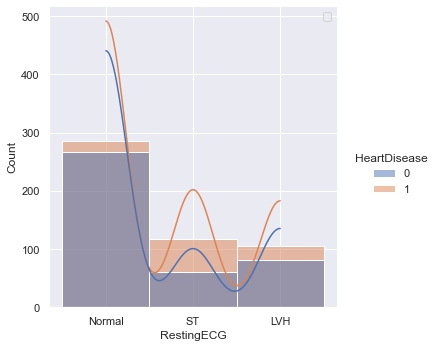

<Figure size 432x288 with 0 Axes>

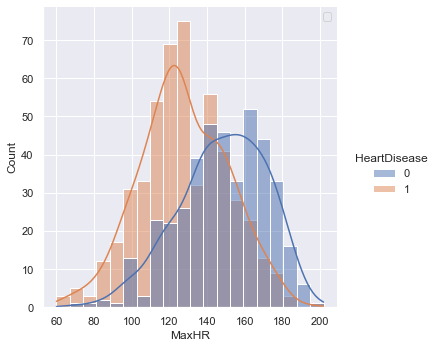

<Figure size 432x288 with 0 Axes>

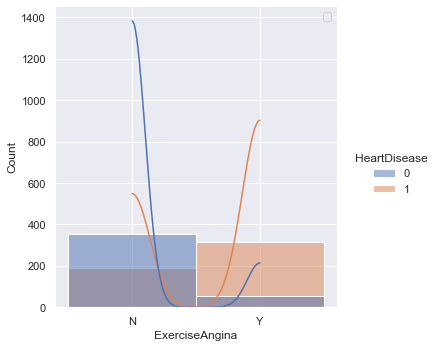

<Figure size 432x288 with 0 Axes>

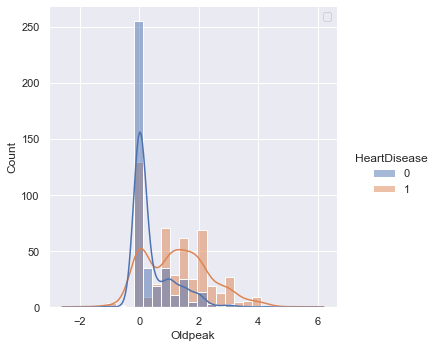

<Figure size 432x288 with 0 Axes>

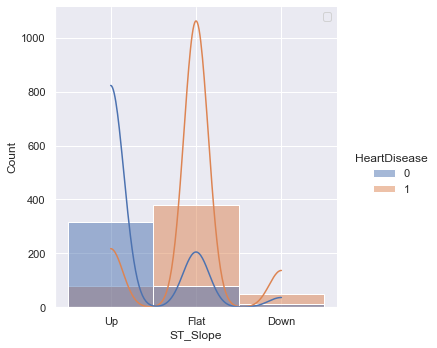

In [12]:
for col in df0.drop(columns='HeartDisease', axis=1).columns:
    plt.figure()
    sns.displot(df0, x=col, hue="HeartDisease", kde=True)
    plt.legend()

In [13]:
df0[df0['Cholesterol']<10]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [14]:
df0[df0['RestingBP']<10]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [15]:
df0[df0['RestingBP']>190]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1
399,61,M,NAP,200,0,1,ST,70,N,0.0,Flat,1
732,56,F,ASY,200,288,1,LVH,133,Y,4.0,Down,1
759,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1


In [16]:
df0.drop_duplicates().shape

(918, 12)

# Tests d'hypothèses


On réalise un test d'ANOVA pour tester si les moyennes des deux distributions.

H0: Les taux moyens sont EGAUX chez les individus non malades et malades.

In [17]:
from scipy.stats import ttest_ind

In [18]:
df=df0.copy()

In [19]:
df.shape

(918, 12)

In [20]:
df=df[df['RestingBP']>0]

In [21]:
df.shape

(917, 12)

In [22]:
mean_cholesterol=int(df[df['Cholesterol']>0]['Cholesterol'].mean())
print(mean_cholesterol)
df['Cholesterol'] = df['Cholesterol'].replace(0, mean_cholesterol)

244


In [23]:
df_disease=df[df['HeartDisease']==1]
df_normal=df[df['HeartDisease']==0]

In [24]:
print(df_disease.shape)
print(df_normal.shape)

(507, 12)
(410, 12)


On doit équilibrer les deux datasets car le ttest est sensible à la taille de chaque échantillon:

In [25]:
balanced_df_disease=df_disease.sample(df_normal.shape[0])

In [26]:
def t_test(col):
    alpha=0.05
    stat,p=ttest_ind(df_normal[col], balanced_df_disease[col])
    if p<alpha:
        return ['H0 rejetée',p]
    else: 
        return [0,p]

In [27]:
for col in df.drop(columns='HeartDisease', axis=1).select_dtypes('int'):
    print(f'{col:-<50} {t_test(col)[0]}' + ' avec p_value='+ f'{t_test(col)[1]}')

Age----------------------------------------------- H0 rejetée avec p_value=4.889506727146708e-15
RestingBP----------------------------------------- H0 rejetée avec p_value=0.0005484468593110987
Cholesterol--------------------------------------- H0 rejetée avec p_value=0.008361686469215836
FastingBS----------------------------------------- H0 rejetée avec p_value=9.008534830588575e-15
MaxHR--------------------------------------------- H0 rejetée avec p_value=3.6987441633699923e-34


In [28]:
for col in df.drop(columns='HeartDisease', axis=1).select_dtypes('float'):
    print(f'{col:-<50} {t_test(col)[0]}' + ' avec p_value='+ f'{t_test(col)[1]}')

Oldpeak------------------------------------------- H0 rejetée avec p_value=2.5107581316555562e-36


Toutes les hypothèses H0 ont été rejetées à alpha=0.05 sur les variables quantitatives --> Les taux moyens des variables quantitatives SONT STATISTIQUEMENT DIFFERENTS chez les individus non malades et malades.

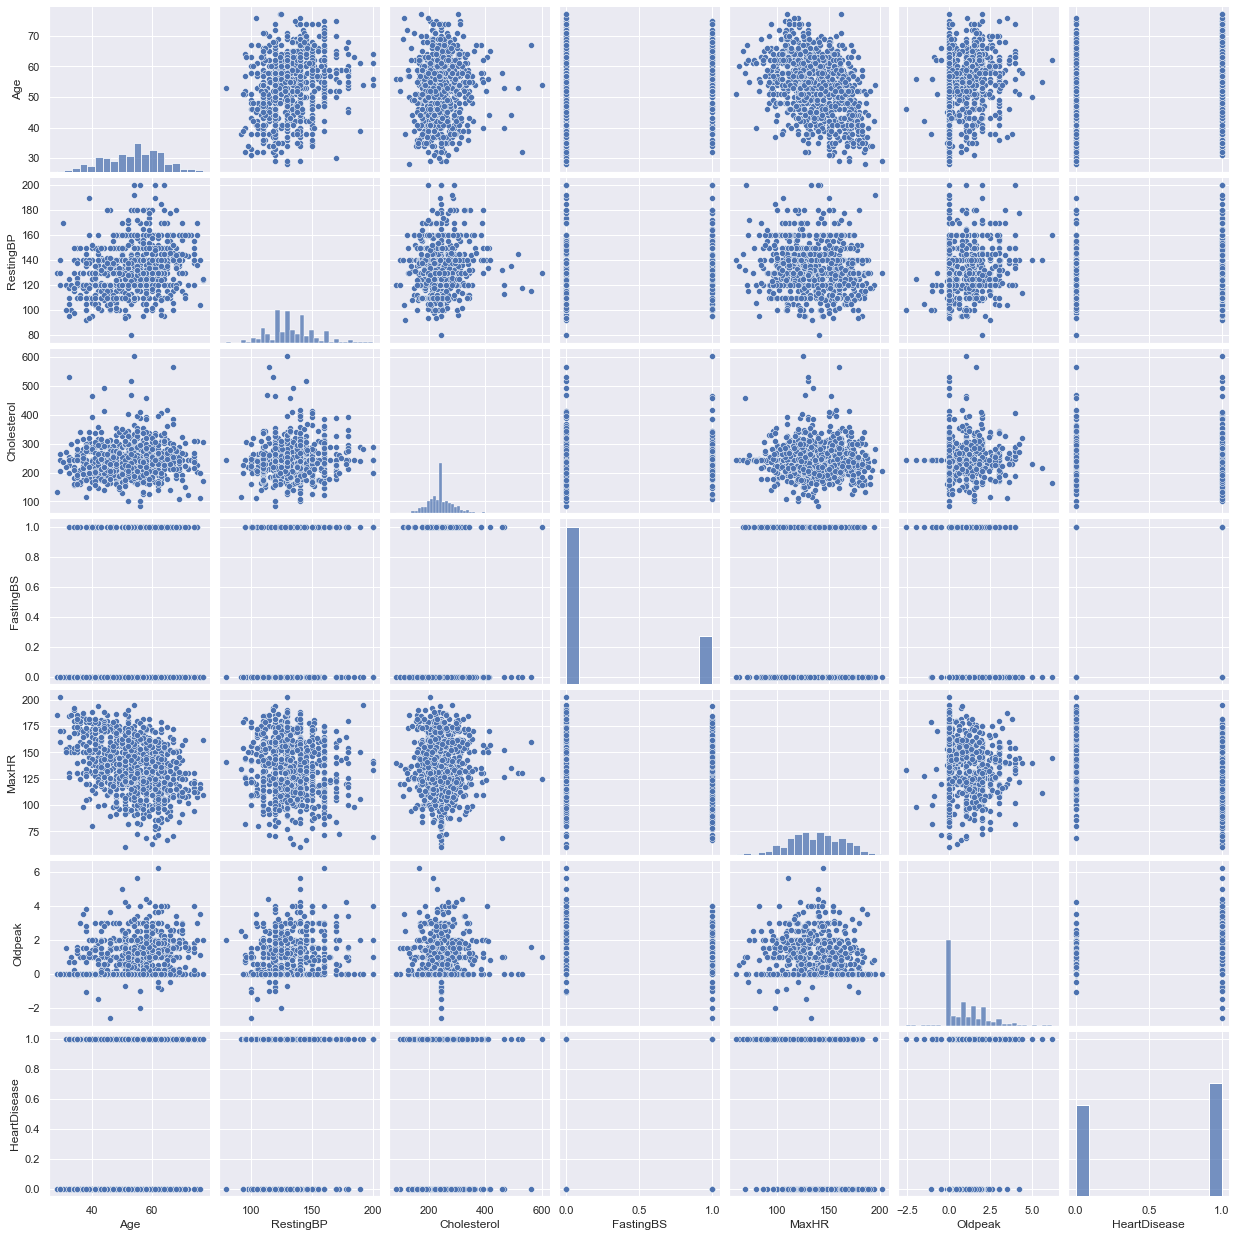

In [29]:
sns.pairplot(df)
plt.show()

In [30]:
corr_matrix=df.corr()
corr_matrix["HeartDisease"].sort_values(ascending=False)

HeartDisease    1.000000
Oldpeak         0.403638
Age             0.282012
FastingBS       0.267994
RestingBP       0.117990
Cholesterol     0.092636
MaxHR          -0.401410
Name: HeartDisease, dtype: float64

In [31]:
X=df.drop('HeartDisease', axis=1)
y=df['HeartDisease']

# 2. Preprocessing

In [32]:
df=df0.copy()

In [33]:
from sklearn.model_selection import train_test_split
df_train, df_test=train_test_split(df, test_size=0.2, random_state=0)

In [34]:
def cleaning(df):
    df=df.drop('ExerciseAngina',axis=1)
    df=df.drop('FastingBS',axis=1)
    df=df[df['RestingBP']>0]
    
    mean_cholesterol=int(df[df['Cholesterol']>0]['Cholesterol'].mean())
    df['Cholesterol'] = df['Cholesterol'].replace(0, mean_cholesterol)

    return df

In [35]:
def encodage(df):
    dict_to_replace={'M':0,'F':1,'ATA':0,'NAP':1,'ASY':2,'TA':3,'Normal':0,'ST':1,'LVH':2,'Down':0,'Flat':1,'Up':2}
    df=df.replace(dict_to_replace)
    return df

In [36]:
def feature_engineering(df):
    
    return df

In [37]:
def preprocessing(df):
    df=cleaning(df)
    df=feature_engineering(df)
    df=encodage(df)

    X=df.drop(columns=['HeartDisease'],axis=1)
    y=df['HeartDisease']

    return X,y

In [38]:
X_train,y_train=preprocessing(df_train)

In [39]:
X_train.shape

(733, 9)

In [40]:
X_test,y_test=preprocessing(df_test)

In [41]:
X_test.shape

(184, 9)

# 3. Modélisation

### Définition des modèles

In [42]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif #(test de anova)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [109]:
preprocessor=make_pipeline(PolynomialFeatures(degree=2),SelectKBest(f_classif, k=10))

In [110]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(),SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [111]:
dict_of_models = {'RandomForest':RandomForest,'AdaBoost': AdaBoost,'SVM': SVM,'KNN': KNN}

### Procédure d'évaluation

In [112]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [113]:
def evaluation(model, name):
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1,1,10), scoring='f1')
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.title(name)
    plt.legend()

Ici, le modèle est en overfitting --> on peut essayer de sélectionner des variables! 

In [114]:
# pd.DataFrame(model.feature_importances_, index=X_train.columns)

RandomForest
[[61 16]
 [17 90]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.79        77
           1       0.85      0.84      0.85       107

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184

None
AdaBoost
[[61 16]
 [19 88]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        77
           1       0.85      0.82      0.83       107

    accuracy                           0.81       184
   macro avg       0.80      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184

None
SVM
[[55 22]
 [22 85]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        77
           1       0.79      0.79      0.79       107

    accuracy                           0.76       184
   macro avg       0.75      0.75  

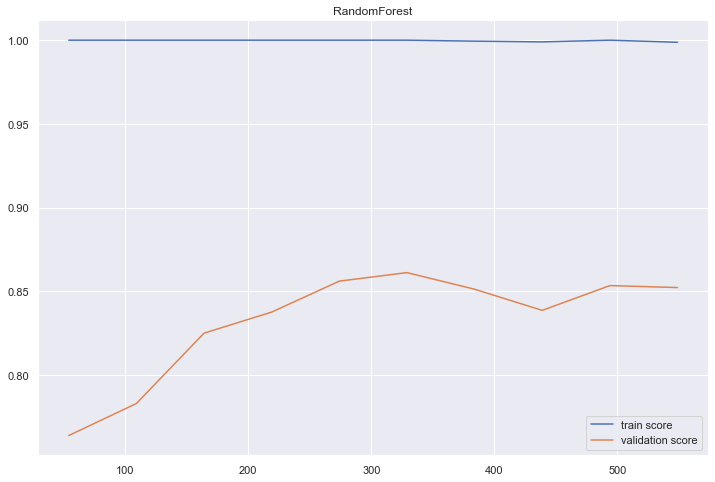

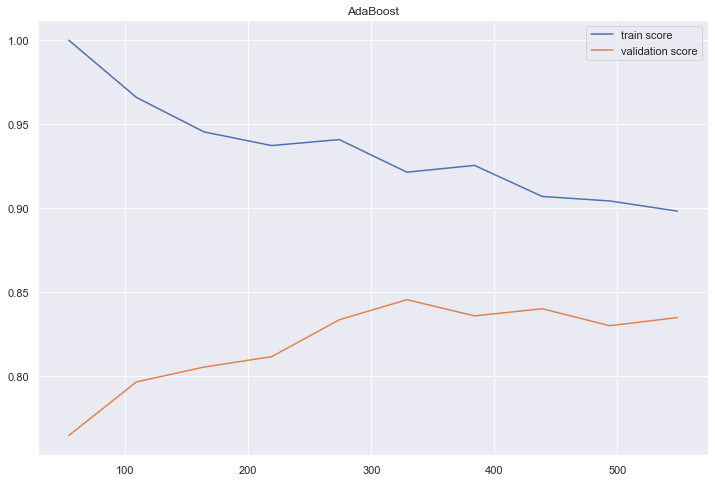

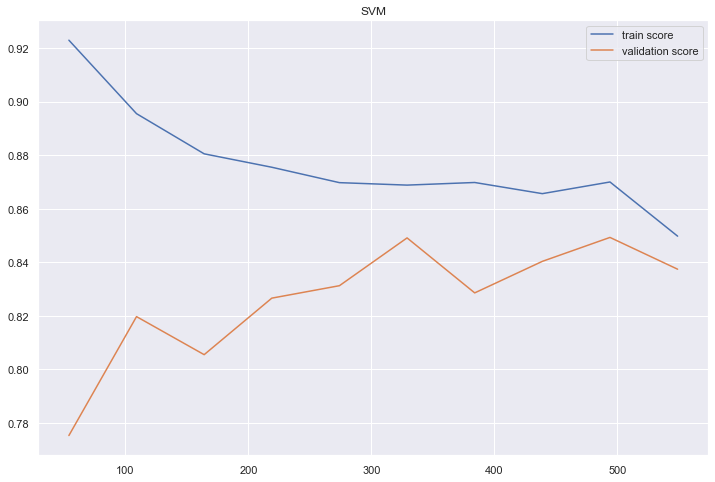

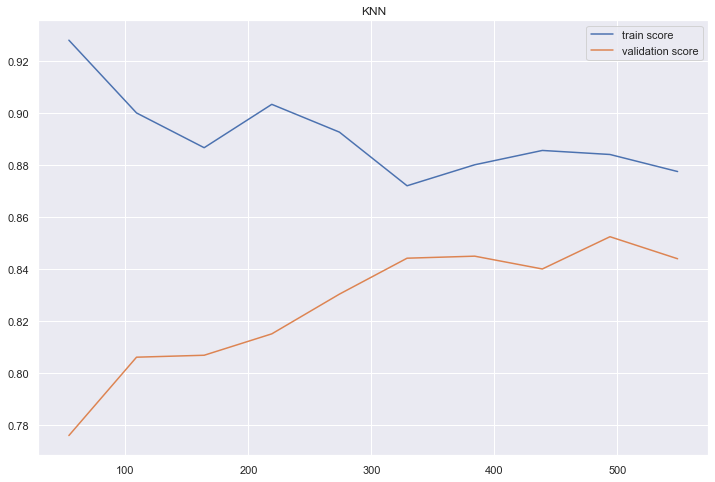

In [127]:
for name, model in dict_of_models.items():
    print(name)
    print(evaluation(model, name))

Résultats:
Sauf pour le random forest, les trois algorithmes (SVM, KNN et Adaboost) ne sont pas en situation d'overfitting, et montrent affichent tous les trois des scores plutôt bons (f1_score > 80)
Optimisons par exemple les paramètres du modèle AdaBoost pour la suite de l'étude.

# 4. Optimisation SVM

### Définition des modèles

Dans cette partie, l'objectif est d'optimiser les paramètres du modèle SVM pour effectuer de meilleures prédictions. On se base sur l'évaluation du f1_score.

In [128]:
from sklearn.model_selection import GridSearchCV

In [129]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [130]:
from sklearn.model_selection import GridSearchCV

In [131]:
hyper_params={'svc__gamma':[1e-3, 1e-4,1e-5], 'svc__C': [1,10,100,1000]}

In [132]:
grid = GridSearchCV(SVM, hyper_params, scoring='f1', cv=4)

In [133]:
grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('polynomialfeatures',
                                                         PolynomialFeatures()),
                                                        ('selectkbest',
                                                         SelectKBest())])),
                                       ('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=0))]),
             param_grid={'svc__C': [1, 10, 100, 1000],
                         'svc__gamma': [0.001, 0.0001, 1e-05]},
             scoring='f1')

In [139]:
print(grid.best_params_)

{'svc__C': 1, 'svc__gamma': 0.001}


In [140]:
y_pred = grid.predict(X_test)

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        77
           1       0.79      0.79      0.79       107

    accuracy                           0.76       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.76      0.76      0.76       184



[[55 22]
 [22 85]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        77
           1       0.79      0.79      0.79       107

    accuracy                           0.76       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.76      0.76      0.76       184



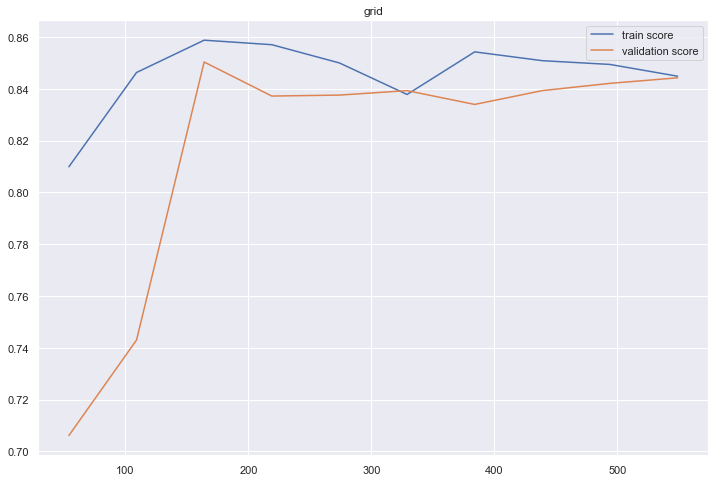

In [142]:
evaluation(grid.best_estimator_, 'grid')

### Optimisation avec RandomizedSearchCV

In [143]:
from sklearn.model_selection import RandomizedSearchCV

In [145]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [164]:
hyper_params_randomized={'svc__gamma':[1e-3, 1e-3, 1e-4],
                        'svc__C': [1,3,5,10],
                        'pipeline__polynomialfeatures__degree':[2,3,4],
                        'pipeline__selectkbest__k': range(60,80)}

In [166]:
grid_randomized = RandomizedSearchCV(SVM, hyper_params_randomized, scoring='f1', cv=4, n_iter=100)

In [167]:
grid_randomized.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('polynomialfeatures',
                                                               PolynomialFeatures()),
                                                              ('selectkbest',
                                                               SelectKBest())])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(random_state=0))]),
                   n_iter=100,
                   param_distributions={'pipeline__polynomialfeatures__degree': [2,
                                                                                 3,
                                                                                 4],
                                        'pipeline__selectkbest__k': range(60, 80),
                                        'svc__C': [1, 3, 5, 10],
                                        'svc__gamma': [0.001, 0.001, 0.0001]},
                   scoring='f1')

In [168]:
print(grid_randomized.best_params_)

{'svc__gamma': 0.0001, 'svc__C': 1, 'pipeline__selectkbest__k': 77, 'pipeline__polynomialfeatures__degree': 3}


In [169]:
y_pred=grid_randomized.predict(X_test)

In [170]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72        77
           1       0.79      0.83      0.81       107

    accuracy                           0.78       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.78      0.78      0.78       184



[[56 21]
 [17 90]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        77
           1       0.81      0.84      0.83       107

    accuracy                           0.79       184
   macro avg       0.79      0.78      0.79       184
weighted avg       0.79      0.79      0.79       184



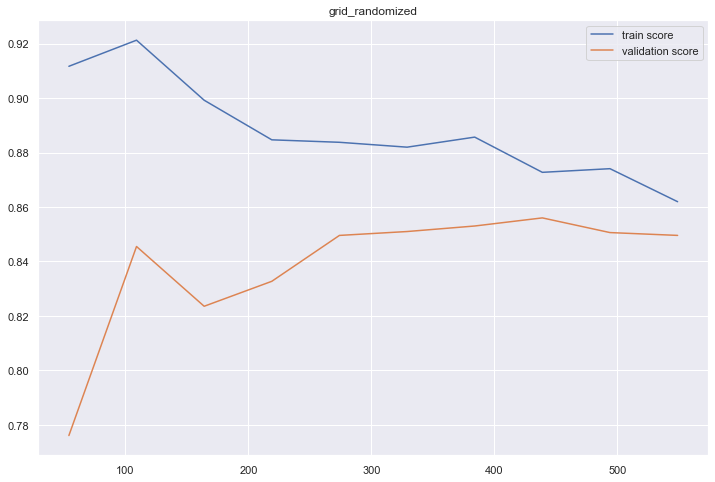

In [174]:
evaluation(grid_randomized, 'grid_randomized')